# Sudoku Solver By ma-as
<i>backtracking with Convolutional Neural Network (CNN)</i>
## :)
Sudoku solver is simple project to test in real life my CNN model. I was testing several models and this one works great, but it's very slow, that's why this sudoku solver solves only sudokus from pictures, not from camera in real time.<br> <br>
Frist we have to import some libraries to create model:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2


from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

%matplotlib inline

Ok, so right now its time to create model

In [2]:
def create_model():
    model = Sequential()
    #i think 24 is a little to much, but idc
    model.add(Conv2D(24,(3,3), kernel_initializer = 'he_uniform',
                                input_shape = (64,64,1),
                                activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=10, activation='softmax'))

    return model

Model is ready, but we need some data to feed it. Let's create dataframe with pictures of numbers.<br>
I asked one on reddit for some dataset with numbers other than mnist and some cool redditor send me one. So only think to do was train my model on this data. I putted all picures into single padas dataframe.

In [3]:
def create_dataset():
    loc = os.getcwd()
    path = loc + '/myData'
    data = []
    labels = []

    for i in range(10):
        files = os.listdir(path +"/"+str(i))
        for file in files:
            path_file = path + "/" + str(i) + "/" + file
            data.append(path_file)
            labels.append(i)

    dictP_n = {"X": data,
              "Y": labels}

    data  = pd.DataFrame(dictP_n, index = None)
    data = data.sample(frac = 1)
    data.to_csv("numbers_in_pd.csv", index =None)

And now we are almost ready! But first we have to load images and prepare them to feed model.

In [9]:
def make_it_better(path):
    x=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(64,64))
    x = (255-x)
    x = x.astype('float32')
    x /= 255
    x = np.asarray(x)
    return x

def train_model(model, plts=True):
    df = load_dataset('numbers_in_pd.csv')
    x = df.X
    X = np.array([make_it_better(el) for el in x])
    Y = df.Y

    # X_train = tf.expand_dims(X, axis=-1)

    X = X.astype('float32')
    X /= 255
    X = X.reshape((-1, 64, 64, 1))
    Y = np_utils.to_categorical(Y, 10)

    X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=10)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(Y_train.shape)
    trained_model_noreg = model.fit(X_train, Y_train, epochs=50, batch_size=100, validation_split=0.2)

    if plts:
        model_history = trained_model_noreg
        plt.plot(model_history.history['accuracy'])
        plt.plot(model_history.history['val_accuracy'])
        plt.title('Dokładność modelu')
        plt.ylabel('dokładność')
        plt.xlabel('epoki')
        plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
        plt.show()
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('Funkcja błędu modelu')
        plt.ylabel('funkcja błędu')
        plt.xlabel('epoki')
        plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
        plt.show()
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

    print('\nTest accuracy:', test_acc)
    model.save('my_model')

    return model

def load_dataset(path):
    df = pd.read_csv(path)
    return df

(9856, 10)
Epoch 1/50
79/79 [==============================] - 11s 130ms/step - loss: 1.6335 - accuracy: 0.5033 - val_loss: 0.8402 - val_accuracy: 0.7779
Epoch 2/50
79/79 [==============================] - 12s 147ms/step - loss: 0.6853 - accuracy: 0.7981 - val_loss: 0.4981 - val_accuracy: 0.8529
Epoch 3/50
79/79 [==============================] - 10s 125ms/step - loss: 0.5116 - accuracy: 0.8508 - val_loss: 0.4137 - val_accuracy: 0.8844
Epoch 4/50
79/79 [==============================] - 10s 126ms/step - loss: 0.4206 - accuracy: 0.8765 - val_loss: 0.3688 - val_accuracy: 0.8955
Epoch 5/50
79/79 [==============================] - 10s 126ms/step - loss: 0.3619 - accuracy: 0.8893 - val_loss: 0.3109 - val_accuracy: 0.9148
Epoch 6/50
79/79 [==============================] - 11s 140ms/step - loss: 0.3113 - accuracy: 0.9061 - val_loss: 0.2728 - val_accuracy: 0.9234
Epoch 7/50
79/79 [==============================] - 11s 140ms/step - loss: 0.2762 - accuracy: 0.9211 - val_loss: 0.2522 - val_accur

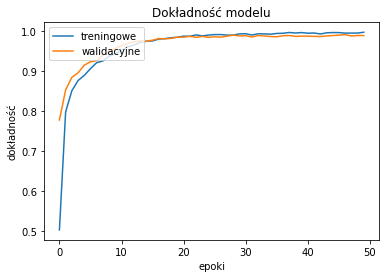

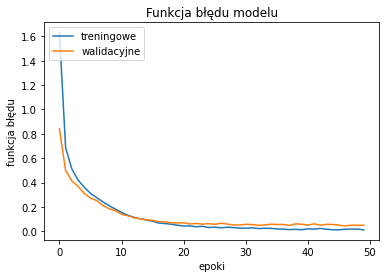

77/77 - 1s - loss: 0.0495 - accuracy: 0.9882

Test accuracy: 0.9882305264472961
INFO:tensorflow:Assets written to: my_model/assets


In [10]:
create_dataset()
model = create_model()
model = train_model(model, plts=True)


ok, model is ready, so now its time to prepare sudoku solving algorithm (backtracking)

In [11]:
def sudoku(p):
    if solve(p):
        return p
        
def solve(puzzle):
    f = find_empty(puzzle)
    if not f:
        return True
    else:
        p1, p2 = f

    for i in range(1, 10):
        if check(puzzle, i, p1, p2):
            puzzle[p1][p2] = i
            if solve(puzzle):
                return True
            puzzle[p1][p2] = 0
    return False

def find_empty(p):
    for i, row in enumerate(p):
        for j, el in enumerate(row):
            if el == 0:
                return i, j
    return None

def check(pu, n, p1, p2):
    for i in range(len(pu)):
        if pu[p1][i] == n and p2 != i:
            return False
    for i in range(len(pu)):
        if pu[i][p2] == n and p1 != i:
            return False
    b_x = p2 // 3
    b_y = p1 // 3
    for i in range(b_y * 3, b_y * 3 + 3):
        for j in range(b_x * 3, b_x * 3 + 3):
            if pu[i][j] == n and (i, j) != (p1, p2):
                return False
    return True

Almost all is done, now we just have to load a photo and play with it a little:

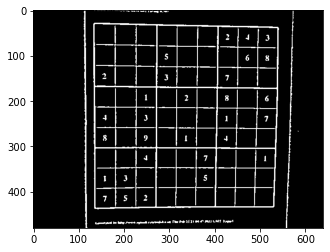

In [59]:
def preprocessing(img):
    imgbw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    proc = cv2.GaussianBlur(imgbw, (3, 3), 1)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C
                                , cv2.THRESH_BINARY, 15, 6)
    proc = cv2.bitwise_not(proc, proc)
    return proc

def preprocessing2(img):
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    proc = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C
                                , cv2.THRESH_BINARY, 9, 2)
    proc = cv2.bitwise_not(proc, proc)
    return proc

img = cv2.imread('0test8.jpg')
imgC = img.copy()
imgT= preprocessing(img.copy())
plt.imshow(imgT,cmap='gray')


This is how photo looks like after preprocesing. It's important because we need to find contours.

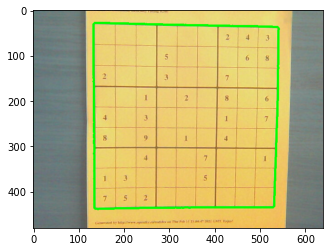

In [60]:
def getContours(img, img2):
    biggest = np.array([])
    maxArea = 0
    contours,hierarhy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for el in contours:
        area = cv2.contourArea(el)
        if area > 5000:
            cv2.drawContours(img2, el, -1, (0,255,0), 3)
            par = cv2.arcLength(el,True)
            approx = cv2.approxPolyDP(el,0.02*par, True)
            if area > maxArea and len(approx) == 4:
                biggest = approx
                maxArea = area
    cv2.drawContours(img2, biggest, -1, (0,255,0), 3)
    return biggest
biggest = getContours(imgT, imgC)
plt.imshow(imgC)

Wrapping:

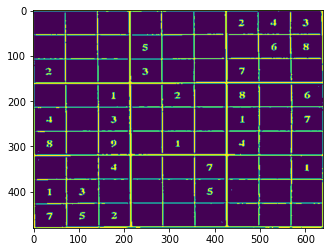

In [61]:
def getWarp(img, biggest):
    biggest = reorganize(biggest)
    p1 = np.float32(biggest)
    p2 = np.float32([[0,0],[img.shape[1]-1,0], [0,img.shape[0]-1],
                     [img.shape[1]-1, img.shape[0]-1]])
    matrix = cv2.getPerspectiveTransform(p1,p2)
    imgWarped = cv2.warpPerspective(img,matrix,(img.shape[1],img.shape[0]))

    return imgWarped


def reorganize(points):
    rp = points.reshape((4, 2))
    rpn = np.zeros((4, 1, 2), np.int32)
    add = rp.sum(1)

    rpn[0] = rp[np.argmin(add)]
    rpn[3] = rp[np.argmax(add)]

    diff = np.diff(rp, axis=1)

    rpn[1] = rp[np.argmin(diff)]
    rpn[2] = rp[np.argmax(diff)]

    return rpn

imgWC = getWarp(img.copy(), biggest)
imgprc = preprocessing(imgWC.copy())
imgprd = preprocessing2(imgWC.copy())
proc = cv2.bitwise_or(imgprd, imgprc)
plt.imshow(proc)

Cool, its time to extract digits from this picture.


In [62]:
def get_digit(img):
    w = img.shape[0]
    h = img.shape[1]
    sqw = w // 9
    sqh = h // 9
    digits = []
    for i in range(9):
        for j in range(9):
            a = img[i*sqw:(i+1)*sqw, j*sqh:(j+1)*sqh]
            a = a[10:-10,15:-15]
            a = cv2.resize(a,(64,64))
            a = a.astype('float32')
            #a = 255-a
            a /= 255
            a = np.asarray(a)
            #a = cv2.cvtColor(a,cv2.COLOR_GRAY2RGB)
            digits.append(a)

    return digits
digits = np.asarray(get_digit(proc))
digits = digits.reshape(-1,64,64,1)

Lets see what model wants to tell us about digits we just extracted

In [63]:
wyn = model.predict(digits.reshape(-1,64,64,1)).argmax(axis=-1)
wyn = wyn.tolist()
k = [wyn[0:9],wyn[9:18],wyn[18:27],
     wyn[27:36],wyn[36:45],wyn[45:54],
     wyn[54:63],wyn[63:72],wyn[72:81]]
for i in range(9):
    print(k[i])

[0, 0, 0, 0, 0, 0, 2, 4, 3]
[0, 0, 0, 5, 0, 0, 0, 6, 8]
[2, 0, 0, 3, 0, 0, 7, 0, 0]
[0, 0, 1, 0, 2, 0, 8, 0, 6]
[4, 0, 3, 0, 0, 0, 1, 0, 7]
[8, 0, 9, 0, 1, 0, 4, 0, 0]
[0, 0, 4, 0, 0, 7, 0, 0, 1]
[1, 3, 0, 0, 0, 5, 0, 0, 0]
[7, 5, 2, 0, 0, 0, 0, 0, 0]


can we solve it?

In [64]:
board = sudoku(k)
for el in board:
    print(el)

[9, 8, 5, 1, 7, 6, 2, 4, 3]
[3, 1, 7, 5, 4, 2, 9, 6, 8]
[2, 4, 6, 3, 8, 9, 7, 1, 5]
[5, 7, 1, 9, 2, 4, 8, 3, 6]
[4, 2, 3, 6, 5, 8, 1, 9, 7]
[8, 6, 9, 7, 1, 3, 4, 5, 2]
[6, 9, 4, 8, 3, 7, 5, 2, 1]
[1, 3, 8, 2, 9, 5, 6, 7, 4]
[7, 5, 2, 4, 6, 1, 3, 8, 9]


Yaaay!

Lets make a function that allow us to load any photo to find a solution.

In [65]:
def solve_it(photo_dir):
    img = cv2.imread(photo_dir)
    imgC = img.copy()
    imgT= preprocessing(img.copy())
    biggest = getContours(imgT, imgC)
    imgWC = getWarp(img.copy(), biggest)
    imgprc = preprocessing(imgWC.copy())
    imgprd = preprocessing2(imgWC.copy())
    proc = cv2.bitwise_or(imgprd, imgprc)
    plt.imshow(proc)
    plt.show()
    digits = np.asarray(get_digit(proc))
    digits = digits.reshape(-1,64,64,1)
    wyn = model.predict(digits.reshape(-1,64,64,1)).argmax(axis=-1)
    wyn = wyn.tolist()
    k = [wyn[0:9],wyn[9:18],wyn[18:27],
         wyn[27:36],wyn[36:45],wyn[45:54],
         wyn[54:63],wyn[63:72],wyn[72:81]]
    print("Empty: \n")
    for i in range(9):
        print(k[i])
    board = sudoku(k)
    print("Solved: \n")
    for el in board:
        print(el)

Its better to use try/except because if there on photo is no sudoku or program have porblems with good classification of digits there is oportunity to crash, and i dont need that, so

In [66]:
def just_put_path_there(path):
    try:
        solve_it(path)
    except:
        print("bad quality photo, model recognized bad digits and now its imposible to solve this sudoku")

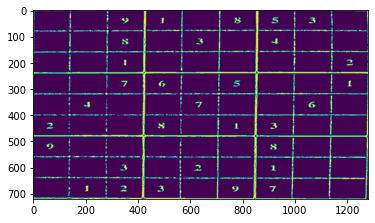

Empty: 

[0, 0, 9, 1, 0, 8, 5, 3, 0]
[0, 0, 8, 0, 3, 0, 4, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 2]
[0, 0, 7, 6, 0, 5, 0, 0, 1]
[0, 4, 0, 0, 7, 0, 0, 6, 0]
[2, 0, 0, 8, 0, 1, 3, 0, 0]
[9, 0, 0, 0, 0, 0, 8, 0, 0]
[0, 0, 3, 0, 2, 0, 1, 0, 0]
[0, 1, 2, 3, 0, 9, 7, 0, 0]
Solved: 

[4, 2, 9, 1, 6, 8, 5, 3, 7]
[5, 6, 8, 7, 3, 2, 4, 1, 9]
[7, 3, 1, 9, 5, 4, 6, 8, 2]
[3, 8, 7, 6, 9, 5, 2, 4, 1]
[1, 4, 5, 2, 7, 3, 9, 6, 8]
[2, 9, 6, 8, 4, 1, 3, 7, 5]
[9, 7, 4, 5, 1, 6, 8, 2, 3]
[8, 5, 3, 4, 2, 7, 1, 9, 6]
[6, 1, 2, 3, 8, 9, 7, 5, 4]


In [67]:
just_put_path_there('3test1.jpg')

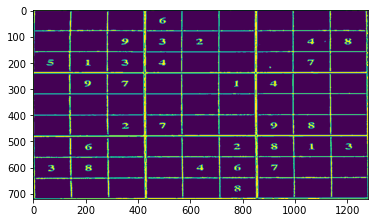

Empty: 

[0, 0, 0, 6, 0, 0, 0, 0, 0]
[0, 0, 9, 3, 2, 0, 0, 4, 8]
[5, 1, 3, 4, 0, 0, 3, 7, 0]
[0, 9, 7, 0, 0, 1, 4, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2, 7, 0, 0, 9, 8, 0]
[0, 6, 0, 0, 0, 2, 8, 1, 3]
[3, 8, 0, 0, 4, 6, 7, 0, 0]
[0, 0, 0, 0, 0, 8, 0, 0, 0]
Solved: 

bad quality photo, model recognized bad digits and now its imposible to solve this sudoku


In [68]:
just_put_path_there('3test7.jpg')